In [235]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
import pandas as pd
from gwpy.timeseries import TimeSeries
import scipy
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle

In [236]:
duration = 4
sampling_frequency = 2048
t0_gps = 1126259460.4
n_samples = duration*sampling_frequency
time = np.linspace(0, duration, n_samples)

delta = 1
ras = np.radians(np.arange(0, 360, delta))
decs = np.radians(np.arange(-90, 90, delta))

ra_s = np.radians(np.linspace(-180, 180, len(ras)+1))
dec_s = np.radians(np.linspace(-90, 90, len(decs)+1))

radec_s = np.array([(ra, dec) for ra in ra_s for dec in dec_s])
radec = np.array([(ra, dec) for ra in ras for dec in decs])

radec_map = radec.reshape(len(decs), len(ras), 2)

In [ ]:
def whiten(strain_df, psd_df):
    return strain_df['h'] / np.sqrt(psd_df['PSD'])

def match_filter(strain_df, waveform_df, IFO, sampling_frequency=sampling_frequency, t0_gps=t0_gps, psi=1):
    mask = strain_df['Hz'] > 20
    S = IFO.power_spectral_density.psd_array
    S[~mask] = np.inf
    best_rhosq = 0
    for ra in ras:
        for dec in decs:
            fplus = IFO.antenna_response(ra, dec, t0_gps, psi, 'plus')
            fcross = IFO.antenna_response(ra, dec, t0_gps, psi, 'cross')
            template = fplus*waveform_df['h+'] + fcross*waveform_df['hx']
            rhosq = 4*np.fft.irfft(strain_df['white']*np.conj(template)/S)*sampling_frequency
            real_rhosq = np.real(rhosq)
            if np.max(real_rhosq) > best_rhosq:
                best_rhosq = np.max(real_rhosq)
                best_ra = ra
                best_dec = dec
                best_rhosqs = real_rhosq
                
    return best_rhosq, best_ra, best_dec, best_rhosqs

def get_tc(snr, time):
    peak_idx = np.argmax(np.abs(snr))
    peak_time = time[peak_idx]
    peak_val = np.abs(snr[peak_idx])
    half_max = peak_val / 2
    indices = np.where(np.abs(snr) > half_max)[0]
    fwhm = time[indices[-1]] - time[indices[0]]
    return peak_time, fwhm

def get_area(ra_grid, dec_grid, errors):
    min_idx = np.argmin(errors)
    min_j, min_i = np.unravel_index(min_idx, errors.shape)
    ra_min = (ra_grid[min_j, min(min_i, ra_grid.shape[1]-2)] + 
          ra_grid[min_j, min(min_i+1, ra_grid.shape[1]-1)]) / 2
    dec_min = (dec_grid[min(min_j, dec_grid.shape[0]-2), min_i] + 
           dec_grid[min(min_j+1, dec_grid.shape[0]-1), min_i]) / 2
    return (ra_min, dec_min)

In [238]:
waveform = np.loadtxt('data/waveform.txt')
h1_strain = np.loadtxt('data/H1_strain.txt')
l1_strain = np.loadtxt('data/L1_strain.txt')
v1_strain = np.loadtxt('data/V1_strain.txt')
h1_psd = np.loadtxt('data/H1_psd.txt')
l1_psd = np.loadtxt('data/L1_psd.txt')
v1_psd = np.loadtxt('data/V1_psd.txt')

In [239]:
waveform = pd.DataFrame(data=waveform, columns=['Hz', 'Re(h+)', 'Im(h+)', 'Re(hx)', 'Im(hx)'])

h1_strain = pd.DataFrame(data=h1_strain, columns=['Hz', 'Re(h)', 'Im(h)'])
l1_strain = pd.DataFrame(data=l1_strain, columns=['Hz', 'Re(h)', 'Im(h)'])
v1_strain = pd.DataFrame(data=v1_strain, columns=['Hz', 'Re(h)', 'Im(h)'])

h1_psd = pd.DataFrame(data=h1_psd, columns=['Hz', 'PSD'])
l1_psd = pd.DataFrame(data=l1_psd, columns=['Hz', 'PSD'])
v1_psd = pd.DataFrame(data=v1_psd, columns=['Hz', 'PSD'])

In [240]:
IFOH = bilby.gw.detector.InterferometerList(['H1'])[0]
IFOH.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=h1_psd['Hz'].values, psd_array=h1_psd['PSD'].values)
# IFOH.frequency_array = h1_psd['Hz']

IFOL = bilby.gw.detector.InterferometerList(['L1'])[0]
IFOL.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=l1_psd['Hz'].values, psd_array=l1_psd['PSD'].values)
# IFOL.frequency_array = l1_psd['Hz']

IFOV = bilby.gw.detector.InterferometerList(['V1'])[0]
IFOV.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=v1_psd['Hz'].values, psd_array=v1_psd['PSD'].values)
# IFOV.frequency_array = v1_psd['Hz']

In [241]:
waveform['h+'] = waveform['Re(h+)'] + 1j*waveform['Im(h+)']
waveform['hx'] = waveform['Re(hx)'] + 1j*waveform['Im(hx)']

h1_strain['h'] = h1_strain['Re(h)'] + 1j*h1_strain['Im(h)']
l1_strain['h'] = l1_strain['Re(h)'] + 1j*l1_strain['Im(h)']
v1_strain['h'] = v1_strain['Re(h)'] + 1j*v1_strain['Im(h)']

h1_strain['white'] = whiten(h1_strain, h1_psd)
l1_strain['white'] = whiten(l1_strain, l1_psd)
v1_strain['white'] = whiten(v1_strain, v1_psd)

snr_H1 = match_filter(h1_strain, waveform, IFOH)[-1]
snr_L1 = match_filter(l1_strain, waveform, IFOL)[-1]
snr_V1 = match_filter(v1_strain, waveform, IFOV)[-1]

tc_H1, fwhm_H1 = get_tc(snr_H1, time)
tc_L1, fwhm_L1 = get_tc(snr_L1, time)
tc_V1, fwhm_V1 = get_tc(snr_V1, time)

waveform.to_csv('data/waveform_2.txt', index=None, sep=' ', mode='a')
h1_strain.to_csv('data/H1_strain_2.txt', index=None, sep=' ', mode='a')
l1_strain.to_csv('data/L1_strain_2.txt', index=None, sep=' ', mode='a')
v1_strain.to_csv('data/V1_strain_2.txt', index=None, sep=' ', mode='a')
h1_psd.to_csv('data/H1_psd_2.txt', index=None, sep=' ', mode='a')
l1_psd.to_csv('data/L1_psd_2.txt', index=None, sep=' ', mode='a')
v1_psd.to_csv('data/V1_psd_2.txt', index=None, sep=' ', mode='a')

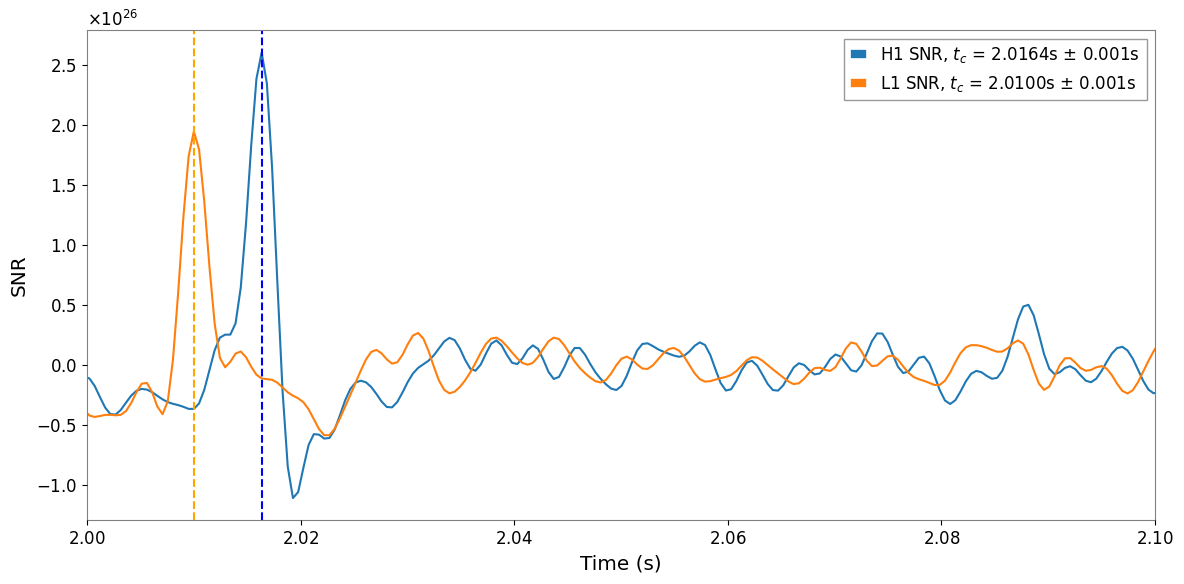

In [242]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(time, snr_H1, label=fr'H1 SNR, $t_c$ = {tc_H1:.4f}s ± {fwhm_H1/2:.3f}s')
ax.plot(time, snr_L1, label=fr'L1 SNR, $t_c$ = {tc_L1:.4f}s ± {fwhm_L1/2:.3f}s')
ax.axvline(tc_H1, color='blue', linestyle='--')
ax.axvline(tc_L1, color='orange', linestyle='--')
ax.grid()
ax.legend()
ax.set_xlim(2, 2.1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('SNR')
plt.tight_layout()
plt.savefig('figures/HL_snr.png')
plt.show()

In [243]:
print(fr"TIME DELAY (H1-L1): {tc_H1-tc_L1:.4f} ± {(fwhm_H1 + fwhm_L1)/2:.5f} s")

TIME DELAY (H1-L1): 0.0063 ± 0.00195 s


In [244]:
h1_time_delays = []
l1_time_delays = []
v1_time_delays = []
for ra in ras:
    for dec in decs:
        h1_time_delays.append(IFOH.time_delay_from_geocenter(ra, dec, t0_gps+tc_H1))
        l1_time_delays.append(IFOL.time_delay_from_geocenter(ra, dec, t0_gps+tc_L1))
        v1_time_delays.append(IFOV.time_delay_from_geocenter(ra, dec, t0_gps+tc_V1))

hl_td = np.array(h1_time_delays) - np.array(l1_time_delays)
lh_td = np.array(l1_time_delays) - np.array(h1_time_delays)
hv_td = np.array(h1_time_delays) - np.array(v1_time_delays)
vl_td = np.array(v1_time_delays) - np.array(l1_time_delays)

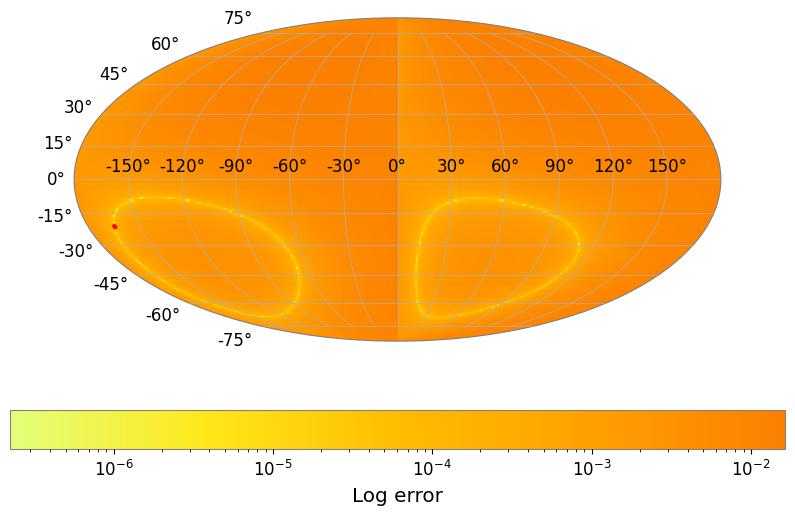

In [245]:
errors = np.sqrt((hl_td - (tc_H1-tc_L1))**2).reshape(len(decs), len(ras))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')
ra_grid, dec_grid = np.meshgrid(ra_s, dec_s)
heatmap = ax.pcolormesh(ra_grid, dec_grid, errors, shading='auto', cmap='Wistia', norm=LogNorm(vmin=errors.min(), vmax=errors.max()))
cbar = fig.colorbar(heatmap, ax=ax, orientation='horizontal')
area = get_area(ra_grid, dec_grid, errors)
circle = Circle((area[0],area[1]), 
                radius=0.01,
                edgecolor='red', 
                facecolor='none', 
                linewidth=2,
                transform=ax.transData)
ax.add_patch(circle)
cbar.set_label('Log error')
plt.savefig('figures/HL_skymap.png', bbox_inches='tight', dpi=300)
plt.show()

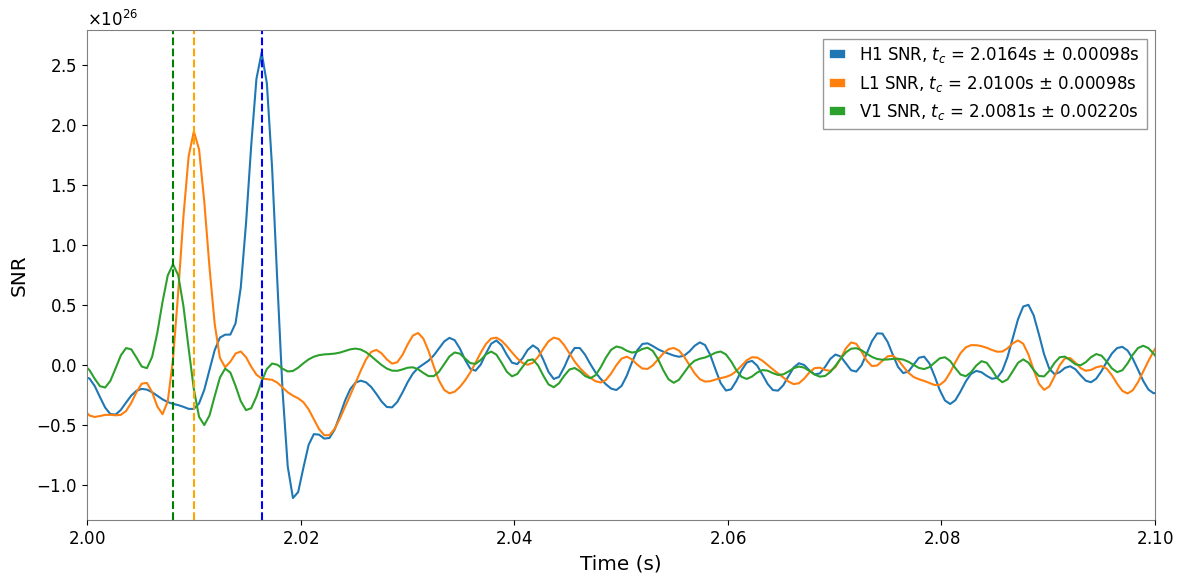

In [246]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(time, snr_H1, label=fr'H1 SNR, $t_c$ = {tc_H1:.4f}s ± {fwhm_H1/2:.5f}s')
ax.plot(time, snr_L1, label=fr'L1 SNR, $t_c$ = {tc_L1:.4f}s ± {fwhm_L1/2:.5f}s')
ax.plot(time, snr_V1, label=fr'V1 SNR, $t_c$ = {tc_V1:.4f}s ± {fwhm_V1/2:.5f}s')
ax.axvline(tc_H1, color='blue', linestyle='--')
ax.axvline(tc_L1, color='orange', linestyle='--')
ax.axvline(tc_V1, color='green', linestyle='--')
ax.grid()
ax.legend()
ax.set_xlim(2, 2.1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('SNR')
plt.tight_layout()
plt.savefig('figures/HVL_snr.png')
plt.show()

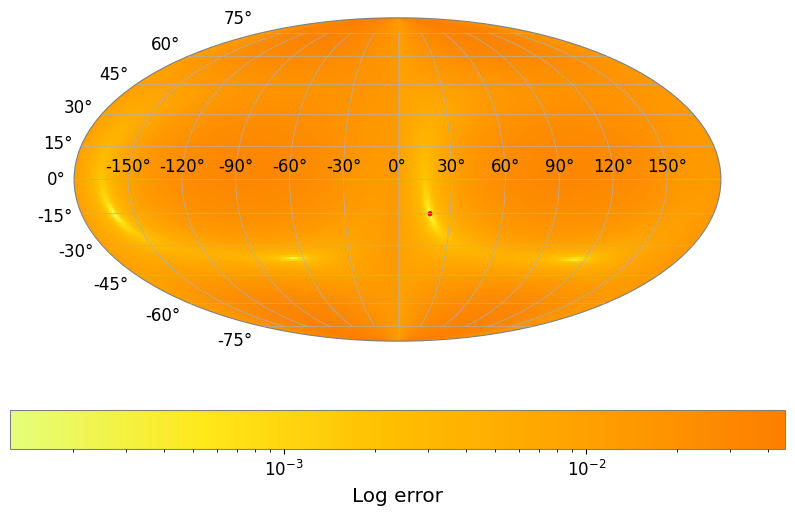

0.0001235963327630621
0.00014711290489397295


In [247]:
errors = np.sqrt((lh_td - (tc_L1-tc_H1))**2 + (hv_td - (tc_H1-tc_V1))**2 + (vl_td - (tc_V1-tc_L1))**2).reshape(len(decs), len(ras))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='mollweide')
heatmap = ax.pcolormesh(ra_grid, dec_grid, errors, shading='auto', cmap='Wistia', norm=LogNorm(vmin=errors.min(), vmax=errors.max()))
cbar = fig.colorbar(heatmap, ax=ax, orientation='horizontal')
cbar.set_label('Log error')
area = get_area(ra_grid, dec_grid, errors)
circle = Circle((area[0],area[1]), 
                radius=0.01,
                edgecolor='red', 
                facecolor='none', 
                linewidth=2,
                transform=ax.transData)
ax.add_patch(circle)
plt.savefig('figures/HVL_skymap.png', bbox_inches='tight', dpi=300)
plt.show()

A, B = np.partition(errors.flatten(), 1)[0:2]
print(A)  # 1
print(B)  # 2